# Analysis of the results from the exhaustive search
The aim of this notebook is to provide an entry point to load and examine the results of the exhaustive search (refer to the [slides](https://docs.google.com/presentation/d/1oM7ku6P3PQmedqPK8HbmT6sLXDTMLCvqNvha3dEJIQo/edit#slide=id.g289f605654f_2_76) for more information)

### Files description

Files are: 
- `<model>_<dataset>_val_results.csv`
- `<model>_<dataset>_val_results_raw.pkl`
      
where `model` can be `acf`, `ecf`, `uprotomf`, `iprotomf`, `uiprotomf` and `dataset` is `ml1m`
Both files are structured as key -> value files.
Key is `(prototype_index,lambda)` (e.g. (30,0.3) which refers to the results of when prototype at index 30 was weakened with a lambda of 0.3).
Key (-1,1) is a special key. It refers to the base case where no prototype is modified.
Value depends on the file:
- `*val_results_raw.pkl` contains all results returned by the evaluator. Each entry is a dictionary with all metrics. (e.g. dict[key]['ndcg@5'] returns the ndcg@5 and so on)
- `*val_results.csv` contains selected results for the analysis already placed in a dataframe for convenience.

Selected results focus on the following metrics:
- ndcg@10
- precision@10
- recall@10
- hellinger_distance@100
- jensen_shannon_distance@100
- kl_divergence@100

For each of these metrics, 4 values are computed are in `*val_results.csv`:
- the metric over all users (e.g. `ndcg@10`)
- the metric over all males (e.g. `group_0_ndcg@10`)
- the metric over all females (e.g. `group_1_ndcg@10`)
- the recgap in percentage (e.g. `recgap(ndcg@10`) To see what RecGap refers to, check the [slides](https://docs.google.com/presentation/d/1oM7ku6P3PQmedqPK8HbmT6sLXDTMLCvqNvha3dEJIQo/edit#slide=id.g289f605654f_2_76) 


In [1]:
import ast
import os
import os.path
from typing import Tuple

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pickle as pkl

RESULTS_PATH = './23-10-23'
DATASET = 'ml1m'

In [2]:

def read_csv_results(model_name: str):
    """
    @param model_name: should be in  ['acf', 'ecf', 'uprotomf', 'iprotomf', 'uiprotomf']
    @return: 2 or 3 dataframes
        - base results (pd.Series with .loc[(-1,1)]
        - user side results (pd.Dataframe), None for iprotomf
        - item side results (pd.Dataframe), None for uprotomf
    """

    assert model_name in ['acf', 'ecf', 'uprotomf', 'iprotomf', 'uiprotomf'], "Model name is invalid!"

    csv_path = os.path.join(RESULTS_PATH, f"{model_name}_{DATASET}_val_results.csv")
    df = pd.read_csv(csv_path, index_col=0)

    # Parsing the index
    df.index = df.index.map(ast.literal_eval)

    # Renaming axis
    df.rename_axis(index=['prototype', 'alpha'], inplace=True)
    df = df.sort_index()

    # Slicing results according the model (remapping indexes when needed)
    df_base = df.loc[(-1, 1)]
    df_user_side = None
    df_item_side = None

    if model_name in ['acf', 'ecf']:
        df_user_side = df.loc[0:127]
        df_item_side = df.loc[128:]
        df_item_side.index = df_item_side.index.map(lambda x: (x[0] - 128, x[1]))
    elif model_name == 'uprotomf':
        df_user_side = df.loc[0:]
    elif model_name == 'iprotomf':
        df_item_side = df.loc[0:]
    elif model_name == 'uiprotomf':
        df_user_side = df.loc[0:41]
        df_item_side = df.loc[42:]
        df_item_side.index = df_item_side.index.map(lambda x: (x[0] - 42, x[1]))
    else:
        raise ValueError('How did you get here?')

    return df_base, df_user_side, df_item_side


def plot_column_heatmap(df_results: pd.DataFrame, df_base_results: pd.Series, result_column: str,
                        higher_is_good: bool = True, figsize: Tuple = (30, 6)):
    """
    Plot the heatmap for a specific column for all prototypes.
    @param df_results: 
    @param df_base_results: 
    @param result_column: name of the column
    @param higher_is_good: is True then blue is associated with high values. Otherwise red is.
    @param figsize: 
    @return: 
    """

    sns.set(rc={'figure.facecolor': 'white'})
    fig, ax = plt.subplots(figsize=figsize)

    center = df_base_results[result_column]
    plot_values = df_results[result_column].unstack()
    plot_values[1.0] = center
    plot_values = plot_values[plot_values.columns[::-1]].transpose()

    if higher_is_good:
        palette = sns.diverging_palette(20, 220, as_cmap=True)
    else:
        palette = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(plot_values, center=center, cmap=palette)

    plt.title(result_column)
    plt.ylabel('Lambda')
    plt.xlabel('Prototype index')
    plt.xticks(rotation=0)

def read_raw_results(model_name: str):
    assert model_name in ['acf', 'ecf', 'uprotomf', 'iprotomf', 'uiprotomf'], "Model name is invalid!"
    
    pkl_path = os.path.join(RESULTS_PATH, f"{model_name}_{DATASET}_val_results_raw.pkl")
    
    with open(pkl_path,'rb') as in_file:
        raw_results = pkl.load(in_file)
    
    return raw_results
    

### Loading csv file
Looking at the data

In [3]:
df_base, df_user_side, df_item_side = read_csv_results('acf')
df_base

ndcg@10                                 0.074073
group_0_ndcg@10                         0.075599
group_1_ndcg@10                         0.070208
recgap(ndcg@10)                         7.278388
precision@10                            0.052022
group_0_precision@10                    0.054600
group_1_precision@10                    0.045492
recgap(precision@10)                   17.508575
recall@10                               0.079008
group_0_recall@10                       0.079530
group_1_recall@10                       0.077685
recgap(recall@10)                       2.335542
hellinger_distance@100                  0.166113
group_0_hellinger_distance@100          0.163915
group_1_hellinger_distance@100          0.171681
recgap(hellinger_distance@100)         -4.675237
jensen_shannon_distance@100             0.224941
group_0_jensen_shannon_distance@100     0.222074
group_1_jensen_shannon_distance@100     0.232201
recgap(jensen_shannon_distance@100)    -4.501812
kl_divergence@100   

In [4]:
df_user_side

ndcg@10  group_0_ndcg@10  group_1_ndcg@10  recgap(ndcg@10)  \
prototype alpha                                                                
0         0.0    0.073957         0.075490         0.070073         7.324023   
          0.1    0.073955         0.075484         0.070081         7.305060   
          0.3    0.073956         0.075495         0.070058         7.352573   
          0.5    0.074008         0.075504         0.070217         7.144096   
          0.7    0.073959         0.075479         0.070109         7.261170   
...                   ...              ...              ...              ...   
127       0.1    0.074081         0.075439         0.070641         6.476733   
          0.3    0.074078         0.075466         0.070563         6.618990   
          0.5    0.074029         0.075448         0.070435         6.771503   
          0.7    0.074070         0.075512         0.070418         6.878374   
          0.9    0.074158         0.075675         0.070316         7.226312   

                 precision@10  group_0_precision@10  group_1_precision@10  \
prototype alpha                                                             
0         0.0        0.052005              0.054716              0.045141   
          0.1        0.052005              0.054716              0.045141   
          0.3        0.051989              0.054739              0.045023   
          0.5        0.052022              0.054739              0.045141   
          0.7        0.051889              0.054646              0.044906   
...                       ...                   ...                   ...   
127       0.1        0.052105              0.054600              0.045785   
          0.3        0.052088              0.054623              0.045667   
          0.5        0.052005              0.054554              0.045550   
          0.7        0.052022              0.054600              0.045492   
          0.9        0.052072              0.054669              0.045492   

                 recgap(precision@10)  recall@10  group_0_recall@10  ...  \
prototype alpha                                                      ...   
0         0.0               18.411886   0.078892           0.079623  ...   
          0.1               18.411886   0.078870           0.079592  ...   
          0.3               18.687452   0.078867           0.079601  ...   
          0.5               18.450456   0.079012           0.079652  ...   
          0.7               18.770733   0.078926           0.079554  ...   
...                               ...        ...                ...  ...   
127       0.1               16.918901   0.078770           0.079110  ...   
          0.3               17.193466   0.078730           0.079096  ...   
          0.5               17.312675   0.078696           0.079101  ...   
          0.7               17.508574   0.078821           0.079209  ...   
          0.9               17.625035   0.078960           0.079464  ...   

                 group_1_hellinger_distance@100  \
prototype alpha                                   
0         0.0                          0.172175   
          0.1                          0.172180   
          0.3                          0.172192   
          0.5                          0.172116   
          0.7                          0.171900   
...                                         ...   
127       0.1                          0.172164   
          0.3                          0.172139   
          0.5                          0.172068   
          0.7                          0.171958   
          0.9                          0.171786   

                 recgap(hellinger_distance@100)  jensen_shannon_distance@100  \
prototype alpha                                                                
0         0.0                         -4.887945                     0.225259   
          0.1                         -4.887220                     0.225266   
  

In [5]:
# Available columns
df_user_side.columns

Index(['ndcg@10', 'group_0_ndcg@10', 'group_1_ndcg@10', 'recgap(ndcg@10)',
       'precision@10', 'group_0_precision@10', 'group_1_precision@10',
       'recgap(precision@10)', 'recall@10', 'group_0_recall@10',
       'group_1_recall@10', 'recgap(recall@10)', 'hellinger_distance@100',
       'group_0_hellinger_distance@100', 'group_1_hellinger_distance@100',
       'recgap(hellinger_distance@100)', 'jensen_shannon_distance@100',
       'group_0_jensen_shannon_distance@100',
       'group_1_jensen_shannon_distance@100',
       'recgap(jensen_shannon_distance@100)', 'kl_divergence@100',
       'group_0_kl_divergence@100', 'group_1_kl_divergence@100',
       'recgap(kl_divergence@100)'],
      dtype='object')

### Plotting the heatmap

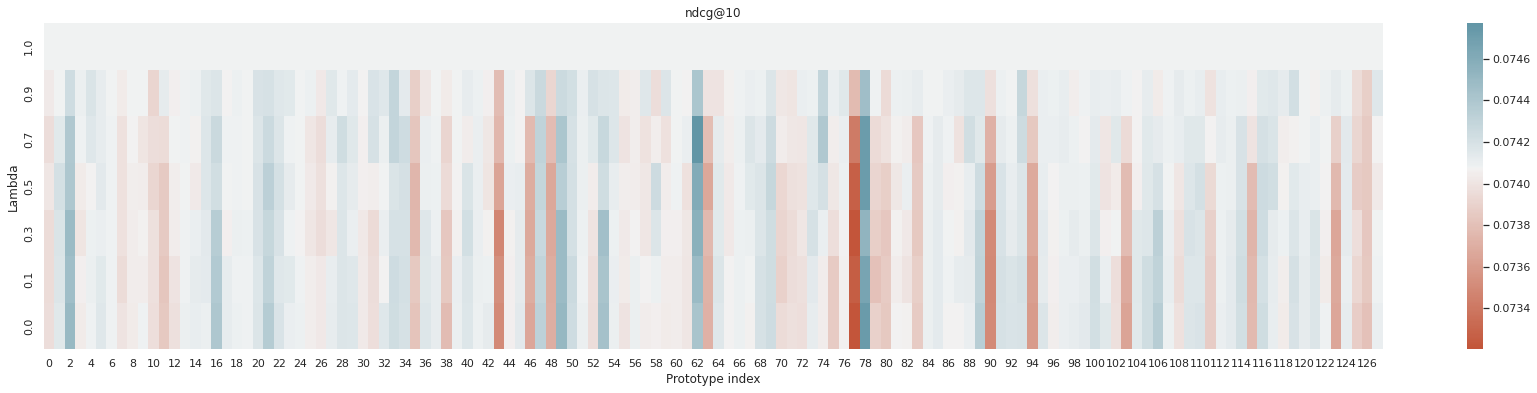

In [6]:
plot_column_heatmap(df_user_side, df_base, 'ndcg@10', higher_is_good=True)

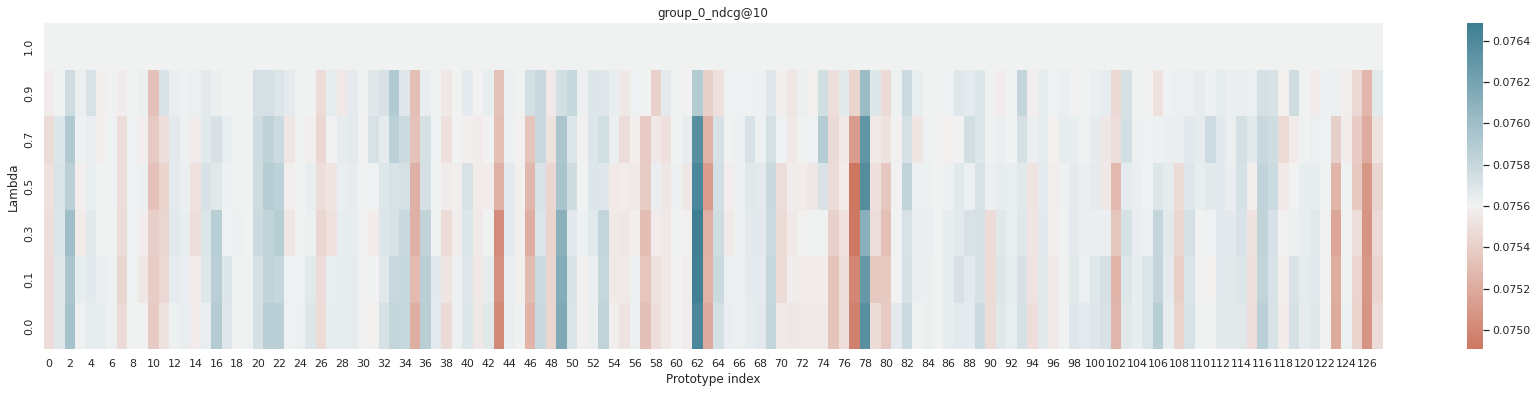

In [7]:
plot_column_heatmap(df_user_side, df_base, 'group_0_ndcg@10', higher_is_good=True)

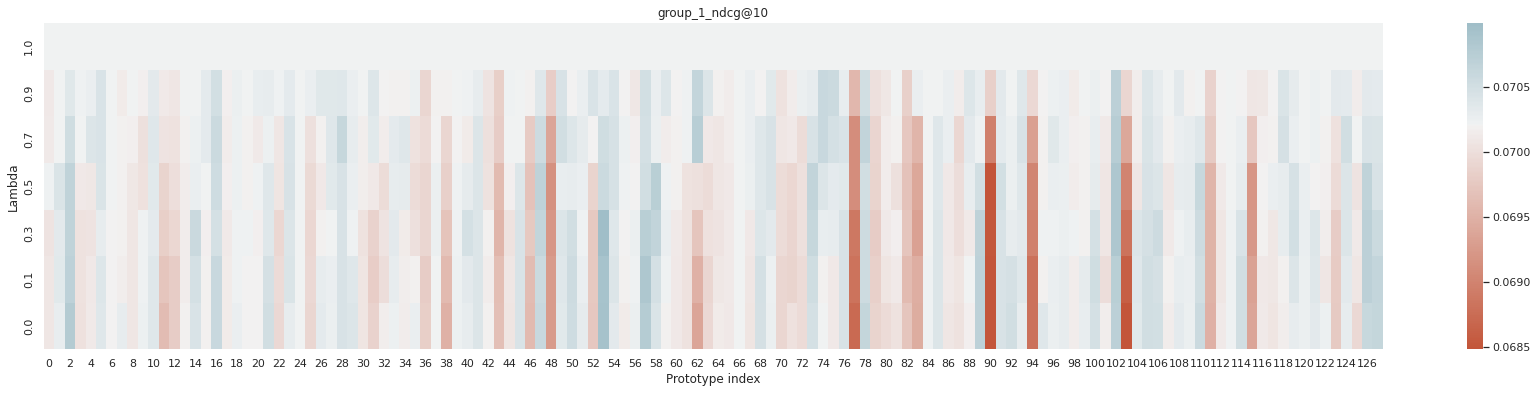

In [8]:
plot_column_heatmap(df_user_side, df_base, 'group_1_ndcg@10', higher_is_good=True)

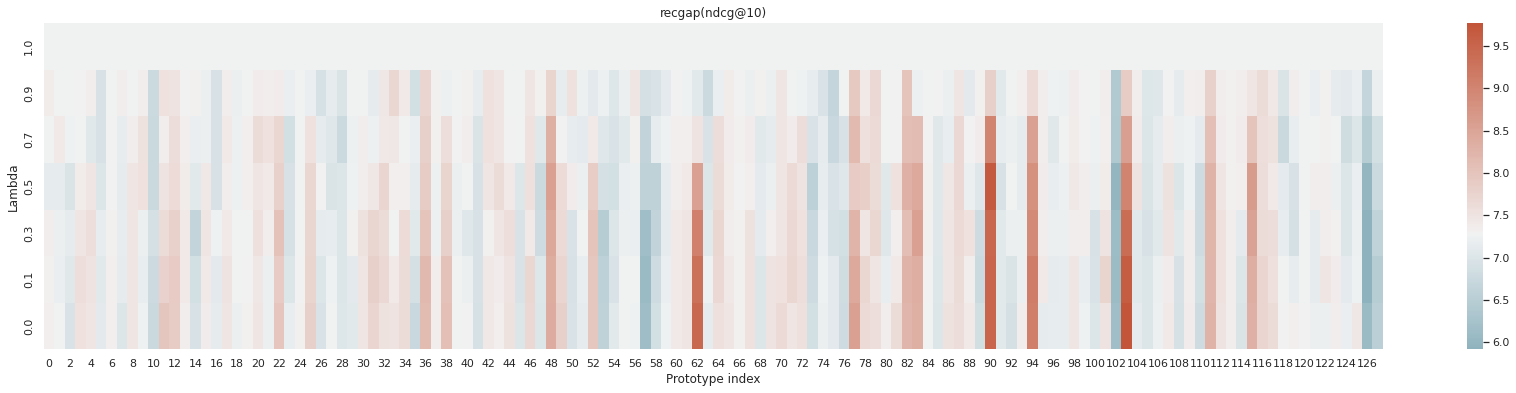

In [9]:
plot_column_heatmap(df_user_side, df_base, 'recgap(ndcg@10)', higher_is_good=False)

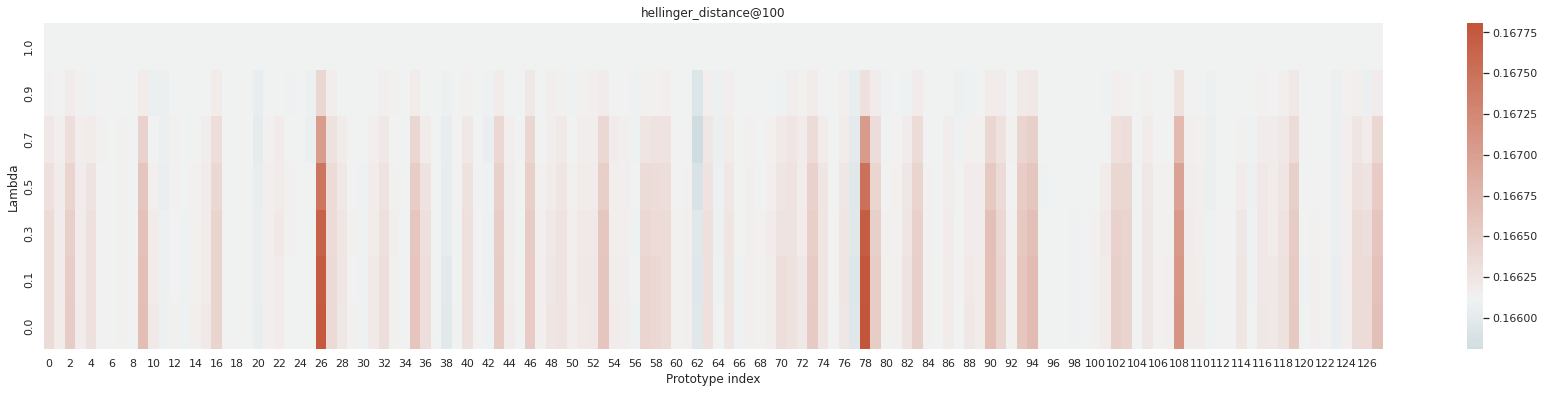

In [10]:
plot_column_heatmap(df_user_side, df_base, 'hellinger_distance@100', higher_is_good=False)

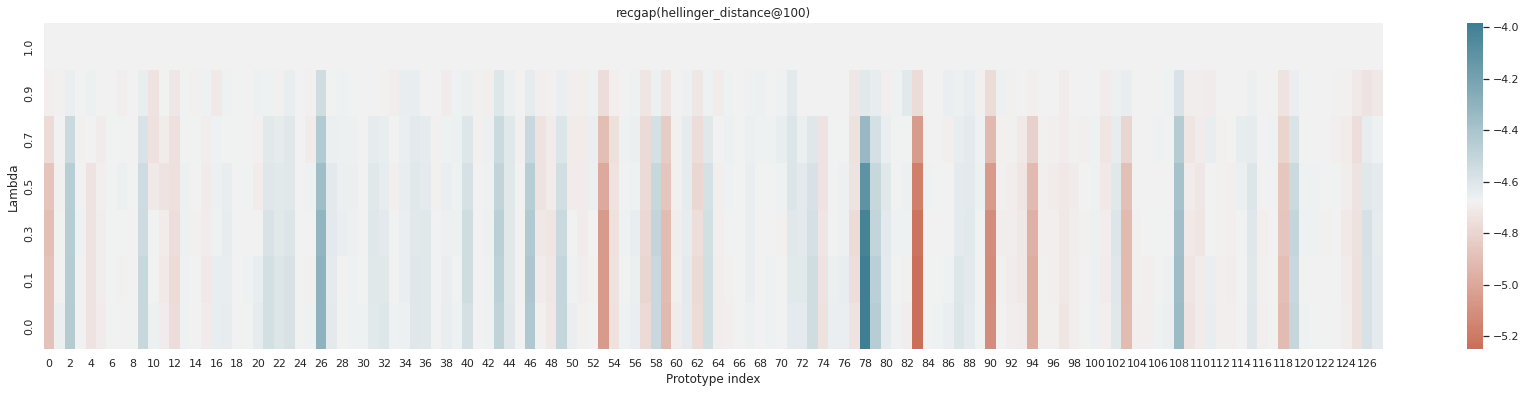

In [11]:
# Watch out here! The recgap is negative so technically a high value is good!
plot_column_heatmap(df_user_side, df_base, 'recgap(hellinger_distance@100)', higher_is_good=True) 

### Looking at the raw results if needed

In [15]:
raw_results = read_raw_results('acf')
raw_results

{(0, 0.9): {'precision@100': 0.03146668739140251,
  'recall@100': 0.40018701268854545,
  'ndcg@100': 0.1784075944677346,
  'precision@50': 0.03829631892940166,
  'recall@50': 0.26014388970756597,
  'ndcg@50': 0.13504023887007136,
  'precision@20': 0.0462711310797588,
  'recall@20': 0.13408834546221618,
  'ndcg@20': 0.09238441732493227,
  'precision@10': 0.05202187701965903,
  'recall@10': 0.07913579678432729,
  'ndcg@10': 0.07402462527812773,
  'precision@5': 0.05694398490411381,
  'recall@5': 0.04170489388267686,
  'ndcg@5': 0.06405653458065176,
  'precision@3': 0.058999007373287615,
  'recall@3': 0.026216792811373825,
  'ndcg@3': 0.06132469870295792,
  'precision@1': 0.06314219423268147,
  'recall@1': 0.009408286397608061,
  'ndcg@1': 0.06314219423268147,
  'hellinger_distance@100': 0.16614059162013453,
  'jensen_shannon_distance@100': 0.22498054290236644,
  'kl_divergence@100': 0.24524293931304203,
  'hellinger_distance@50': 0.1827663660918714,
  'jensen_shannon_distance@50': 0.2458